In [1]:
import numpy as np

import pandas as pd
import glob
import time

from maxij_nicerdefs import *

# from astropy.io import fits
from scipy.signal import fftconvolve


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline


In [2]:
# info for reading x-ray data (directory and filter for night)
# for example, for 3/28 the NICER date is 113
xpathnam = 'delivery/'
filename_filter = 'ni1200120113_0mpu7_silver_GTI*.lc' # for 3/28

# infor to read rho optical data (directory and night)
opathnam = './maxij_data_copies/'
night = '2018-03-28'

In [218]:
# get filenames for night's xray data
ftest = xpathnam + filename_filter
flistD = glob.glob(ftest)

# all files
flist = [fnam.split('/')[1] for fnam in flistD] 

# just first file 
# flist = ['ni1200120113_0mpu7_silver_GTI0-v2-bands.lc']

#read in lightcurves for different energy bands 
#(all, 0, 1, 2, 3&4)
t,cts=rd_nicer_lc(xpathnam,flist)
t0,cts0=rd_nicer_lc0(xpathnam,flist)
t1,cts1=rd_nicer_lc1(xpathnam,flist)
t2,cts2=rd_nicer_lc2(xpathnam,flist)
t34,cts34=rd_nicer_lc34(xpathnam,flist)

In [219]:
flist 

['ni1200120113_0mpu7_silver_GTI7-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI24-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI19-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI0-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI3-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI11-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI2-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI12-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI20-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI15-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI27-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI26-v2-bands.lc',
 'ni1200120113_0mpu7_silver_GTI8-v2-bands.lc']

In [220]:
#read in optical data as pandas dataframe:
rhodata = pd.read_pickle(opathnam+'data_'+night+'.pkl')
# print data
print len(rhodata)

11729


In [221]:
# computer clock is ~8.5s slow (per lab tests + SSE calculation)
# (((POSSIBLY 51.5 s fast, but this is less likely)))
rhodata['fixed_time'] = rhodata['os_time'] -51.5

In [222]:
# do not change this! it is absolutely calibrated to the 28th. 
# unix epoch timestamp - nicer absolute time
# both at 2018-03-28 08:05:21.000 UTC
dt = 1522224321-133689923
print dt

1388534398


In [223]:
t_start = np.min(t) #t[0]
t_start_unix = np.int(t_start + dt) #round down to the second

print "Time at beginning of first NICER observation of the night"
print str(t_start_unix) + " <-- unix epoch timestamp"
print time.strftime('%m/%d/%Y %H:%M:%S',  time.gmtime(t_start_unix)) + " UTC"

Time at beginning of first NICER observation of the night
1522224321 <-- unix epoch timestamp
03/28/2018 08:05:21 UTC


In [224]:
t_stop = np.max(t) 
t_stop_unix = np.int(t_stop + dt)
print "Time at end of last NICER observations for the night"
print time.strftime('%m/%d/%Y %H:%M:%S',  time.gmtime(t_stop_unix)) + " UTC"

Time at end of last NICER observations for the night
03/28/2018 23:27:06 UTC


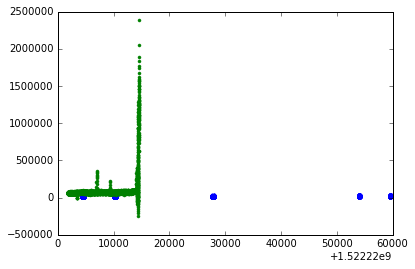

In [225]:
plt.plot(t+dt,cts,'.')
plt.plot(rhodata['fixed_time'],rhodata['phot_maxij'],'.')

(1522221851.54, 1522234534.6099999)

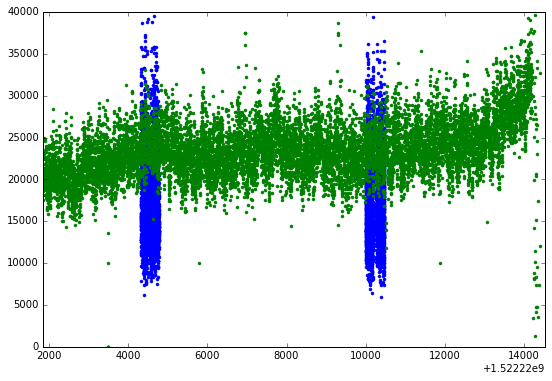

In [226]:
fig,ax=plt.subplots(figsize=[9,6])
ax.plot(t+dt,cts,'.')
ax.plot(rhodata['fixed_time'],rhodata['phot_maxij']/3.,'.')
ax.set_ylim(0,40000)
ax.set_xlim(np.min(rhodata['fixed_time']),np.max(rhodata['fixed_time']))

In [227]:
rhomatch0 = rhodata.loc[rhodata['fixed_time'] > np.min(t+dt)]
rhomatch1 = rhomatch0.loc[rhomatch0['fixed_time'] < np.max(t+dt)]

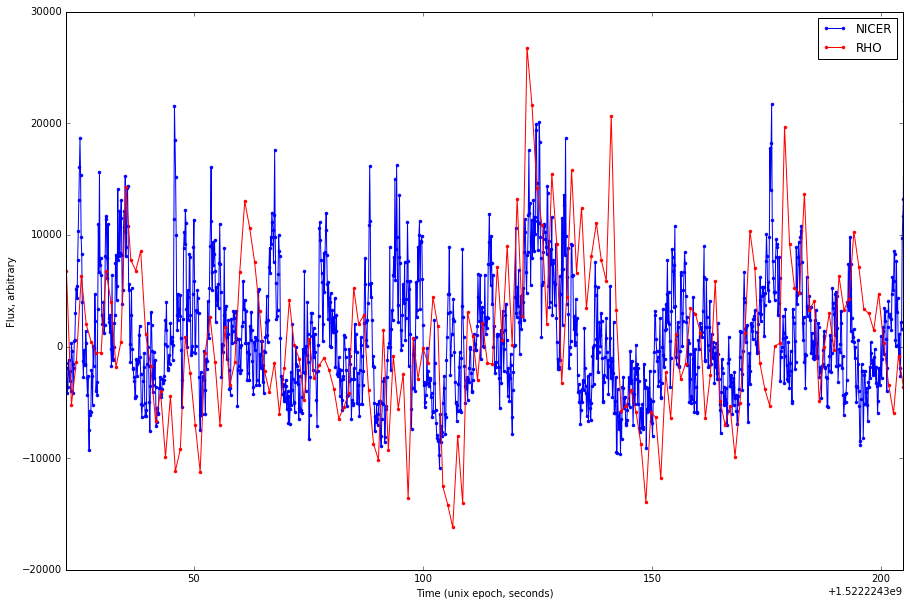

In [188]:
rhomatch = rhomatch1
fig,ax=plt.subplots(figsize=[15,10],facecolor='w')
ax.plot(t+dt,cts-np.median(cts),'.-b')
ax.plot(rhomatch['fixed_time'],rhomatch['phot_maxij']-np.median(rhomatch['phot_maxij']),'.-r')
# ax.set_ylim(0,40000)
ax.set_xlim(np.min(rhomatch['fixed_time']),np.max(rhomatch['fixed_time']))
ax.legend(['NICER','RHO'])
ax.set_xlabel('Time (unix epoch, seconds)')
ax.set_ylabel('Flux, arbitrary')

In [189]:
len(rhomatch)

170

In [190]:
#turn into time series
xray_ts=nicer_lc_2_1sts(t,cts-np.median(cts))
optical_ts = photlc_2_ts(rhomatch['fixed_time'],rhomatch['phot_maxij']-np.median(rhomatch['phot_maxij']))
tycho_ts = photlc_2_ts(rhomatch['fixed_time'],rhomatch['phot_tyc']-np.median(rhomatch['phot_tyc']))

0 184
182
182


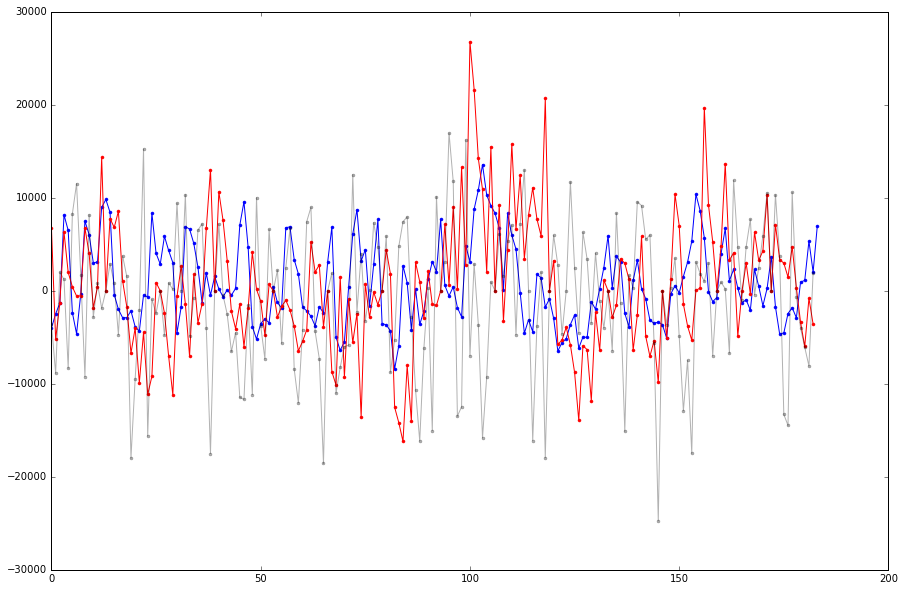

In [255]:
fig,ax=plt.subplots(figsize=[15,10],facecolor='w')
plt.plot(xray_ts/8.,'.-b')
plt.plot(optical_ts,'.-r')
plt.plot(tycho_ts,'.-k',alpha=.3)

In [237]:
tf=np.arange(len(optical_ts))
fx,px,pxtot = pds_chunk128(tf,xray_ts/8.,0,np.max(tf))
fo,po,potot = pds_chunk128(tf,optical_ts,0,np.max(tf))
ft,pt,pttot = pds_chunk128(tf,tycho_ts,0,np.max(tf))

182 1
0 64
182 1
0 64
182 1
0 64


In [258]:
print len(xray_ts)

184


In [239]:
auto_x = fftconvolve(px[0],px[0][::-1]) #x-ray autocorrelation
auto_o = fftconvolve(po[0],po[0][::-1]) #optical autocorrelation
auto_t = fftconvolve(pt[0],pt[0][::-1]) #tycho reference star autocorrelation

crosscorr_xo = fftconvolve(px[0],po[0][::-1]) # cross correlation
crosscorr_xt = fftconvolve(px[0],pt[0][::-1]) # cross corr'ln w/ refstar

63
63


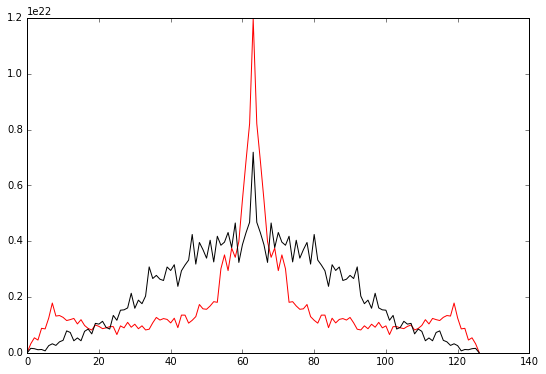

In [240]:
#plot auto correlations
fig,ax=plt.subplots(figsize=[9,6])
# ax.plot(auto_x,'b')
ax.plot(auto_o,'r')
ax.plot(auto_t,'k')
# ax.plot([63.,63.],[0,3.e29],'y',alpha=.7)
# ax.set_ylim(0,9e24)
# ax.set_xlim(40,80)
print np.argmax(auto_x)
print np.argmax(auto_o)

65


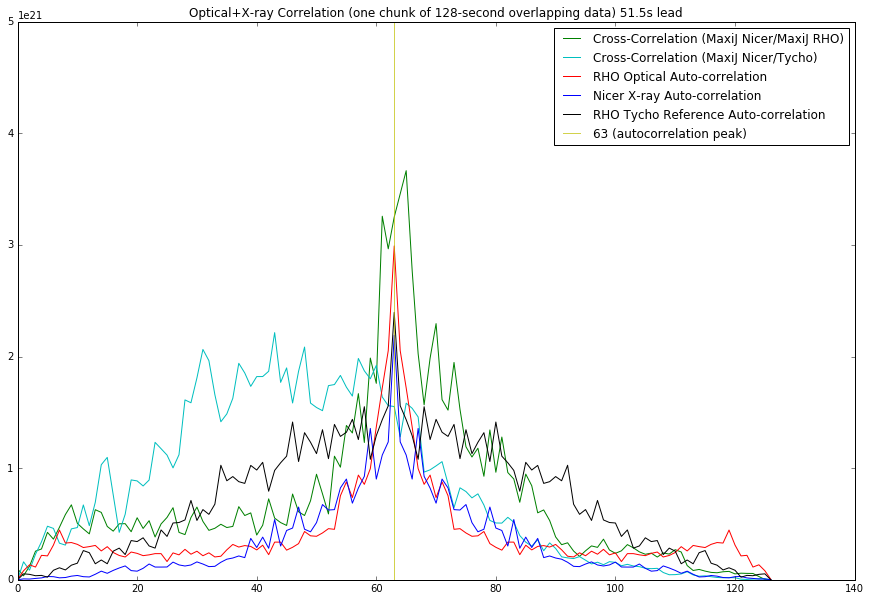

In [251]:
fig,ax=plt.subplots(figsize=[15,10],facecolor='w')
ax.plot(crosscorr_xo,'g')
ax.plot(crosscorr_xt,'c')
ax.plot(auto_o/4,'r')
ax.plot(auto_x,'b')
ax.plot(auto_t/3,'k')
ax.plot([63.,63.],[0,3.e28],'y',alpha=.7)
ax.set_ylim(0,5e21)
# ax.set_xlim(40,80)
ax.set_title('Optical+X-ray Correlation (one chunk of 128-second overlapping data) 51.5s lead')
ax.legend(['Cross-Correlation (MaxiJ Nicer/MaxiJ RHO)',
           'Cross-Correlation (MaxiJ Nicer/Tycho)',
           'RHO Optical Auto-correlation',
           'Nicer X-ray Auto-correlation',
           'RHO Tycho Reference Auto-correlation',
           '63 (autocorrelation peak)'])
print np.argmax(crosscorr_xo)

In [242]:
# #plot correlation but subtract the autocorrelation fn
# fig,ax=plt.subplots(figsize=[9,6])
# # ax.set_xlim(750,850)
# dum1diff = 2*crosscorr_xo-auto_o-auto_x
# ax.plot(dum1diff)
# # ax.set_ylim(-1e10,.5e10)

In [243]:
t_fft = np.arange(len(px[0]))/10.
fft_x=np.fft.fft(px[0])
fft_o=np.fft.fft(po[0])
fft_t=np.fft.fft(pt[0])

In [213]:
nel2=len(fft_x)/2.
f=np.arange(nel2)/np.max(t_fft)

/home/amanda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  
/home/amanda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  This is separate from the ipykernel package so we can avoid doing imports until
/home/amanda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  after removing the cwd from sys.path.


(0, 2e+22)

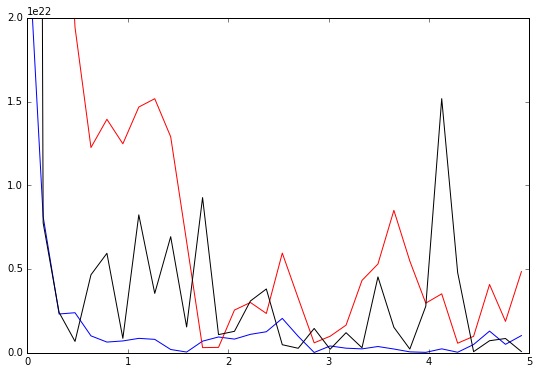

In [214]:
fig,ax=plt.subplots(figsize=[9,6])
ax.plot(f,np.abs(fft_x[:nel2]**2)/.65e4,'b')
ax.plot(f,np.abs(fft_o[:nel2]**2),'r')
ax.plot(f,np.abs(fft_t[:nel2]**2),'k')
ax.set_ylim(0,2e22)

In [215]:
logf,logpx = logbin(fx,pxtot/(pxtot[0]**0.5),0.05)
logf,logpo = logbin(fo,potot/(potot[0]**0.5),0.05)
logf,logpt = logbin(ft,pttot/(pttot[0]**0.5),0.05)

(0.0078125, 1)

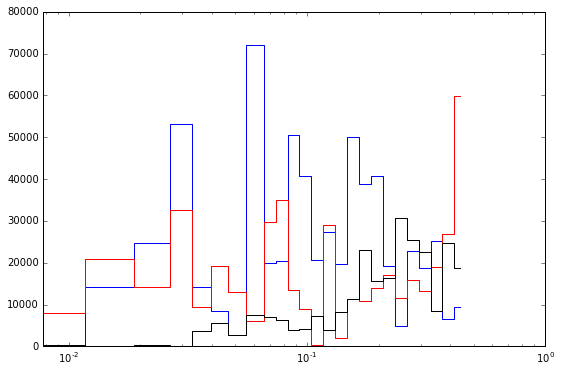

In [216]:
fig,ax=plt.subplots(figsize=(9,6), facecolor='w')
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xscale('log')
ax.plot(10.**logf[logpx>0],(10.**logf[logpx>0.0])*logpx[logpx>0],'b',drawstyle='steps-mid')
ax.plot(10.**logf[logpo>0],(10.**logf[logpo>0.0])*logpo[logpo>0],'r',drawstyle='steps-mid')
ax.plot(10.**logf[logpt>0],(10.**logf[logpt>0.0])*logpt[logpt>0],'k',drawstyle='steps-mid')

ax.set_xlim(0,1)
# ax.set_ylim(0.,1.)

/home/amanda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  
/home/amanda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 5e+23)

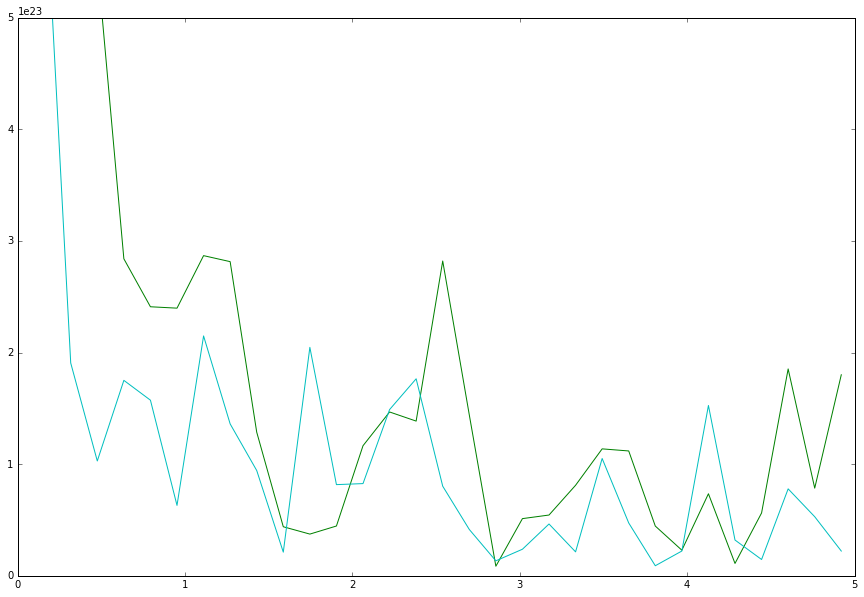

In [217]:
fig,ax=plt.subplots(figsize=[15,10],facecolor='w')
ax.plot(f,np.abs(fft_x[:nel2]*np.conj(fft_o[:nel2])),'g')
ax.plot(f,np.abs(fft_x[:nel2]*np.conj(fft_t[:nel2])),'c')
ax.set_ylim(0,.5e24)

In [231]:
st = 'hello'
print [st for x in np.arange(10)]

['hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello']
